# Example Reading Kerchunk: 
Use the below cells to read an example kerchunk file from the CEDA Archive. This notebook requires some specific python libraries to function, but these can be installed into a conda/virtual environment.

In [1]:
import fsspec
import xarray as xr
import matplotlib.pyplot as plt
import sys
import math
import numpy as np
import ssl

## Useful utility functions 
A simple function to get the name of a variable from a dataset which has three dimensions (assumed to be time, lat, lon)

In [2]:
def find_variable(ds, display=False):
    keepvar = None
    for var in ds.variables:
        if display:
            print(var, len(ds[var].dims))
        if not keepvar and len(ds[var].dims) == 3:
            keepvar = var
    if keepvar == None:
        if not display: # Built-in single recursion in the case of failure to find a correct variable
            find_variable(ds, display=True)
        else:
            return None
    return keepvar

Another useful function for converting from latitude, longitude to array coordinates

In [3]:
def getbox(map_bounds, latn, lonn):
    latmin = int((map_bounds[2]+90)/180 * latn)
    latmax = int((map_bounds[0]+90)/180 * latn)
    
    lonmin = int((map_bounds[3]+180)/360 * lonn)
    lonmax = int((map_bounds[1]+180)/360 * lonn)
    return [latmin, latmax, lonmin, lonmax]

## Standard kerchunk opening sequence
Note: if you are opening a kerchunk file via the dap service that requires authentication, you may use either certificate authentication or token authentication, although the latter is yet to be fully supported. If you require certificate authentication for the kerchunk or underlying netcdf files, it is best to use the following:

In [ ]:
CERT_FILE = '/path/to/cert/file.pem'

def get_ssl_context():
    # Set up ssl context
    ssl_context = ssl.create_default_context(cafile=CERT_FILE, capath=CERT_FILE)
    ssl_context.check_hostname = False
    ssl_context.verify_mode = ssl.CERT_NONE
    return ssl_context

def get_cookies():
    print('Getting Cookies')
    tiny_readme_url = "https://dap.ceda.ac.uk/badc/ukcp18/data/land-cpm/ancil/lsm/lsm_land-cpm_BI_5km.nc"
    cookies = requests.get(tiny_readme_url, cert=CERT_FILE, verify=False).cookies
    return cookies
    
using_auth = False
if using_auth:
    remote_options = {'ssl':get_ssl_context(),'cookies':get_cookies()}

Then the standard kerchunk opening sequence is:

In [10]:
kfile  = 'https://dap.ceda.ac.uk/neodc/esacci/snow/docs/esacci4.json'
mapper = fsspec.get_mapper('reference://', fo=kfile)# add `remote_options=remote_options` for authentication with a certificate
ds     = xr.open_zarr(mapper, consolidated=False)

## Example Use Case for Kerchunk Virtual Dataset
Here we see an example for plotting a standard spatial selection, which for any variable will give an equal size slice in memory.

In [11]:
latn = len(ds.lat)
lonn = len(ds.lon)
timen = len(ds.time)
ref = 1e9

# Determine the standard byte density
# To ensure the plotted box does not exceed the reference value in memory
map_bounds = [52, -1, 51, -2]
[latmin, latmax, lonmin, lonmax] = getbox(map_bounds, latn, lonn)
bytes      = (latmax-latmin)*(lonmax-lonmin)*64*timen
sf         = math.sqrt(ref/bytes)
if sf < 75:
    map_bounds = [
        52 + (sf-1)/2,
        -1 + (sf-1)/2,
        51 - (sf-1)/2,
        -2 - (sf-1)/2
    ]
    [latmin, latmax, lonmin, lonmax] = getbox(map_bounds, latn, lonn)
    bytes = (latmax-latmin)*(lonmax-lonmin)*64*timen
else:
    map_bounds = [90, 180, -90, -180]
    latmin = 0
    latmax = latn
    lonmin = 0
    lonmax = lonn
    bytes = (latmax-latmin)*(lonmax-lonmin)*64*timen

Now that we have a standardised memory size for any dataset, we can now plot a variable.

In [13]:
ds

<xarray.Dataset>
Dimensions:                       (time: 197, lat: 360, lon: 720,
                                   hist_phase: 2, hist1d_cer_bin_centre: 11,
                                   hist1d_cer_bin_border: 12,
                                   hist1d_cla_vis006_bin_centre: 13,
                                   hist1d_cla_vis006_bin_border: 14,
                                   hist1d_cla_vis008_bin_centre: 13,
                                   ...
                                   hist1d_cwp_bin_centre: 14,
                                   hist1d_cwp_bin_border: 15,
                                   hist2d_cot_bin_border: 14,
                                   hist2d_cot_bin_centre: 13,
                                   hist2d_ctp_bin_centre: 15,
                                   hist2d_ctp_bin_border: 16)
Coordinates: (12/22)
  * hist1d_cer_bin_border         (hist1d_cer_bin_border) float32 0.0 ... 80.0
  * hist1d_cer_bin_centre         (hist1d_cer_bin_centre) float32 1.5 ... 70.0
  * hist1d_cla_vis006_bin_border  (hist1d_cla_vis006_bin_border) float32 0.0 ...
  * hist1d_cla_vis006_bin_centre  (hist1d_cla_vis006_bin_centre) float32 0.05...
  * hist1d_cla_vis008_bin_border  (hist1d_cla_vis008_bin_border) float32 0.0 ...
  * hist1d_cla_vis008_bin_centre  (hist1d_cla_vis008_bin_centre) float32 0.05...
    ...                            ...
  * hist2d_ctp_bin_border         (hist2d_ctp_bin_border) float32 1.0 ... 1.1...
  * hist2d_ctp_bin_centre         (hist2d_ctp_bin_centre) float32 45.5 ... 1....
  * hist_phase                    (hist_phase) int8 0 1
  * lat                           (lat) float32 -89.75 -89.25 ... 89.25 89.75
  * lon                           (lon) float32 -179.8 -179.2 ... 179.2 179.8
  * time                          (time) datetime64[ns] 1995-06-01 ... 2012-0...
Data variables: (12/182)
    boa_lwdn                      (time, lat, lon) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    boa_lwdn_clr                  (time, lat, lon) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    boa_lwup                      (time, lat, lon) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    boa_lwup_clr                  (time, lat, lon) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    boa_swdn                      (time, lat, lon) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    boa_swdn_clr                  (time, lat, lon) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    ...                            ...
    toa_swdn                      (time, lat, lon) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    toa_swup                      (time, lat, lon) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    toa_swup_clr                  (time, lat, lon) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    toa_swup_hig                  (time, lat, lon) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    toa_swup_low                  (time, lat, lon) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    toa_swup_mid                  (time, lat, lon) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
Attributes: (12/41)
    Conventions:                 CF-1.6,ACDD-1.3
    NCO:                         4.7.1
    cdm_data_type:               Grid
    comment:                     These data were produced at ESACCI as part o...
    creator_email:               contact.cloudcci@dwd.de
    creator_name:                RAL
    ...                          ...
    time_coverage_duration:      P1M
    time_coverage_end:           20020815T235959Z
    time_coverage_resolution:    P1M
    time_coverage_start:         20020801T000000Z
    title:                       ESA Cloud CCI Retrieval Products L3 Output File
    tracking_id:                 e2a48c64-bd20-11e9-8f5d-506b4b07cefc

Computing for  boa_lwdn


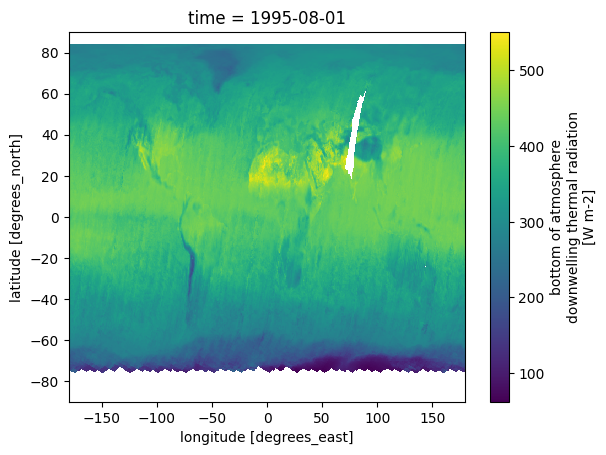

In [12]:
vname = find_variable(ds) # Override if name is known in this dataset
print('Computing for ',vname)
if vname != None:
    var = ds[vname]

    # Identify a time step which contains some data
    timei = -1
    filled = False
    while not filled and timei < timen-1:
        timei += 1
        if np.count_nonzero(np.isnan(var[timei,latmin:latmax,lonmin:lonmax]))/(bytes/(64*timen)) < 1:
            filled = True

    # Plot a non-empty time step with the given spatial selection
    if filled:                                                                       
        var = var[timei,latmin:latmax,lonmin:lonmax]
        var.plot()
    else:
        print('No non-empty time slices found')